<a href="https://colab.research.google.com/github/SouravG/stock-market-prediction/blob/main/stock_market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn import preprocessing
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate,Bidirectional,LeakyReLU
from keras import optimizers,initializers
import numpy as np
np.random.seed(4)
from keras.utils.vis_utils import plot_model
!pip install --upgrade mplfinance

from mplfinance.original_flavor import candlestick_ohlc

history_points = 60# 50

In [ ]:
data = pd.read_csv('/content/cipla 1min.csv')
data.drop('time',axis=1,inplace=True)
data.drop('date',axis=1,inplace=True)
#data.drop(0,inplace=True)
data.dropna(inplace=True)
print(data.head(5),data.shape)
print(data.isnull().any())

     open    high     low   close  volume
0  541.55  543.00  541.55  542.15    6221
1  542.15  542.65  542.00  542.25    9638
2  542.50  542.50  541.20  542.35   10504
3  542.10  542.15  541.50  542.10    7571
4  542.15  543.55  542.00  543.00   11156 (227458, 5)
open      False
high      False
low       False
close     False
volume    False
dtype: bool


In [ ]:
data_normaliser = preprocessing.MinMaxScaler()
data_normalised = pd.DataFrame(data_normaliser.fit_transform(data))
data.corr()

,open,high,low,close,volume
open,1.000000,0.999996,0.999995,0.999993,0.096943
high,0.999996,1.000000,0.999992,0.999996,0.098049
low,0.999995,0.999992,1.000000,0.999996,0.095841
close,0.999993,0.999996,0.999996,1.000000,0.096970
volume,0.096943,0.098049,0.095841,0.096970,1.000000


In [ ]:
def csv_to_dataset(data):
    
    data = data.values
    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)
    print(data_normalised.shape)
    # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(0,len(data_normalised) - history_points,history_points)])
    
    print('ohlcv_histories_normalised', ohlcv_histories_normalised.shape)
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(0,len(data_normalised) - history_points,history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)
    print('next_day_open_values_normalised ', next_day_open_values_normalised.shape)

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(0,len(data) - history_points,history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values)

    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalised:
        # note since we are using his[3] we are taking the SMA of the closing price
        sma = np.mean(his[:,3])
        macd = calc_ema(his, 30) - calc_ema(his, 60)
        #technical_indicators.append(np.array([sma]))
        technical_indicators.append(np.array([sma,macd,]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] #== technical_indicators_normalised.shape[0]
    return ohlcv_histories_normalised, technical_indicators_normalised,next_day_open_values_normalised, next_day_open_values, y_normaliser


In [ ]:
ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset(data)

print(technical_indicators.shape)

(227458, 5)
ohlcv_histories_normalised (3790, 60, 5)
next_day_open_values_normalised  (3790, 1)
(3790, 2)


In [ ]:
test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)
print(next_day_open_values.shape)
print(tech_ind_train.shape)

(3411, 60, 5)
(379, 60, 5)
(3790, 1)
(3411, 2)


In [ ]:

# model architecture

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

# the first branch operates on the first input
x = Bidirectional(LSTM(history_points, name='lstm_0',return_sequences=False))(lstm_input)
#x = Attention(return_sequences=False)(x)
#x = (LSTM(history_points, name='lstm_1',return_sequences=False,bias_initializer=initializers.GlorotNormalV2()))(x)

x = Dropout(0.2, name='lstm_dropout_0')(x)
#x = Bidirectional(LSTM(history_points//10, name='lstm_1'))(x)
#x = Dropout(0.2, name='lstm_dropout_1')(x)

lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = Dense(history_points, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.5, name='tech_dropout_0')(y)
'''
y = Dense(20, name='tech_dense_1')(y)
y = Activation("relu", name='tech_relu_1')(y)
y = Dropout(0.5, name='tech_dropout_1')(y)
'''
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(32, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
adam = optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=adam, loss='mse')
plot_model(model, to_file='model.png')
model.summary()

Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tech_input (InputLayer)         [(None, 2)]          0                                            
__________________________________________________________________________________________________
lstm_input (InputLayer)         [(None, 60, 5)]      0                                            
__________________________________________________________________________________________________
tech_dense_0 (Dense)            (None, 60)           180         tech_input[0][0]                 
__________________________________________________________________________________________________
bidirectional_16 (Bidirectional (None, 120)          31680       lstm_input[0][0]                 
___________________________________________________________________________________________

In [ ]:
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)

Epoch 1/50
96/96 [==============================] - 5s 19ms/step - loss: 0.0092 - val_loss: 2.2863e-04
Epoch 2/50
96/96 [==============================] - 1s 8ms/step - loss: 4.2478e-04 - val_loss: 2.1832e-04
Epoch 3/50
96/96 [==============================] - 1s 8ms/step - loss: 3.0584e-04 - val_loss: 8.2821e-05
Epoch 4/50
96/96 [==============================] - 1s 8ms/step - loss: 3.3132e-04 - val_loss: 0.0012
Epoch 5/50
96/96 [==============================] - 1s 8ms/step - loss: 1.6717e-04 - val_loss: 4.7808e-04
Epoch 6/50
96/96 [==============================] - 1s 8ms/step - loss: 2.0103e-04 - val_loss: 2.6711e-04
Epoch 7/50
96/96 [==============================] - 1s 8ms/step - loss: 1.8201e-04 - val_loss: 9.3241e-05
Epoch 8/50
96/96 [==============================] - 1s 8ms/step - loss: 1.5810e-04 - val_loss: 4.3822e-04
Epoch 9/50
96/96 [==============================] - 1s 9ms/step - loss: 1.7801e-04 - val_loss: 5.9863e-05
Epoch 10/50
96/96 [==============================] - 

386.6844186862337


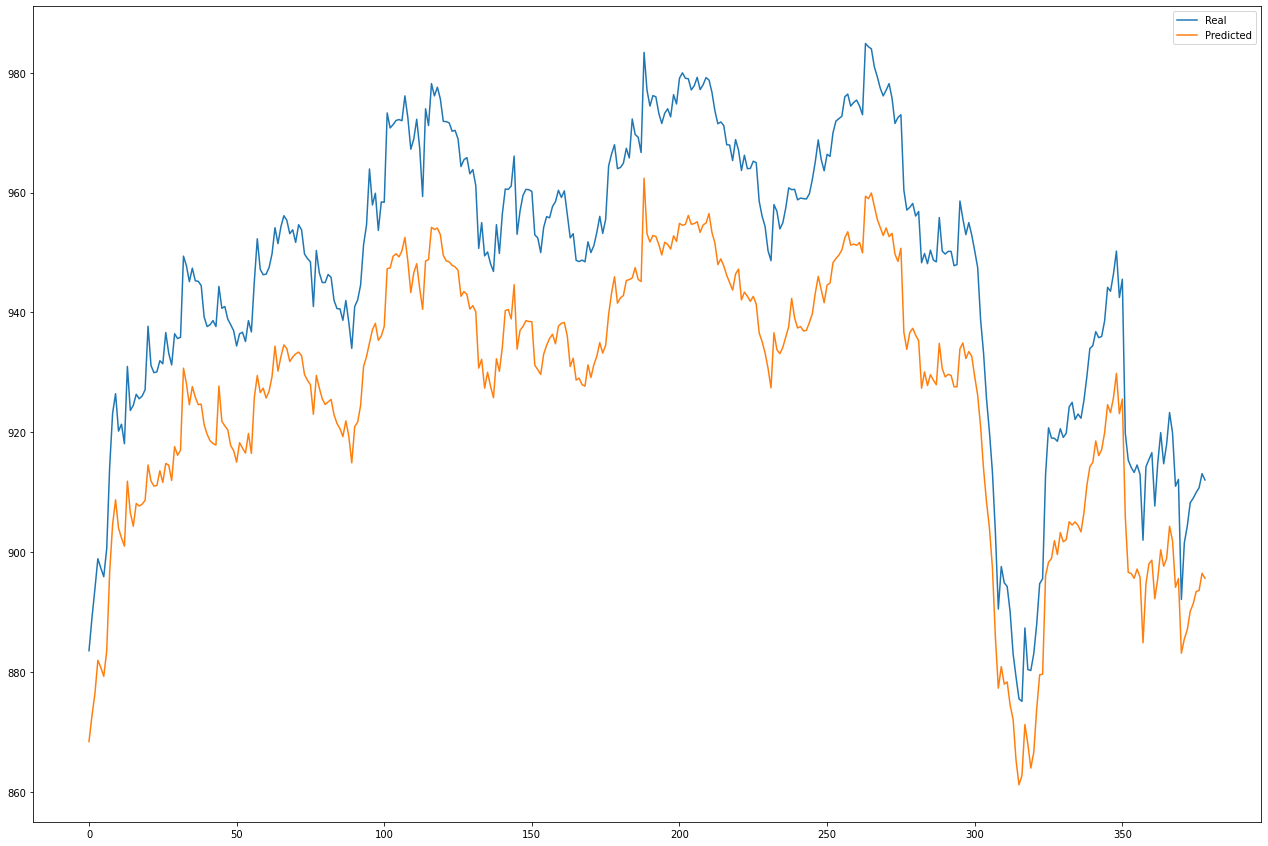

In [ ]:
# evaluation

y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test, label='real')
pred = plt.plot(y_test_predicted, label='predicted')

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

from datetime import datetime
model.save(f'technical_model.h5')